In [110]:
import statistics
import numpy as np
import torch
import sklearn.metrics as skm
import torch
import importlib
import fastai
import tsai
import copy
import shap
import math
importlib.reload(fastai)
importlib.reload(tsai)


from tsai.all import *
from tsai.data.validation import get_splits
from tsai.models.InceptionTimePlus import InceptionTimePlus
from fastai.vision.all import *
from fastai.callback.tracker import EarlyStoppingCallback, ReduceLROnPlateau
from fastai.data.transforms import Categorize
from fastai.losses import FocalLossFlat
from fastai.metrics import accuracy, BrierScore, F1Score, RocAucBinary, APScoreBinary

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


import Data_load_neat as Data_load
import MLmodel_opt_learner_neat as MLmodel_opt_learner

In [111]:
np.set_printoptions(precision=4,suppress = True)

In [112]:
# load in arguments from command line
name = "data_2real5newerbigdet"
model_name="ResNet"
randnum_split=3
epochs=8
device = 1
filepath="/home/DIDE/smishra/Simulations/"
folds=5

In [113]:

X_raw = np.load("".join([filepath,"input_data/",name, "_X.npy"])).astype(np.float32)


Y_raw = np.squeeze(np.load("".join([filepath,"input_data/",name, "_YH.npy"])))
Y = Y_raw[:, np.shape(Y_raw)[1] - 1]

print(X_raw.shape)


(100000, 9, 40)


In [114]:
## Function to obtain the train/test split
X_trainvalid, Y_trainvalid, X_test, Y_test, splits = Data_load.split_data(X=X_raw,Y=Y,randnum=randnum_split)


Random state set:3, cuda used: True
Counter({0.0: 98072, 1.0: 1928}) Counter({0.0: 78458, 1.0: 1542}) Counter({0.0: 19614, 1.0: 386})


In [115]:
# Give the architecture for each model
if model_name=="LSTMFCN":
    arch=LSTM_FCNPlus

if model_name=="TCN":
    arch=TCN

if model_name=="XCM":
    arch=XCMPlus

if model_name=="ResCNN":
    arch=ResCNN

if model_name=="ResNet":
    arch=ResNetPlus

if model_name=="InceptionTime":
    arch=InceptionTimePlus

if model_name=="MLSTMFCN":
    arch=MLSTM_FCNPlus


## Set seed
Data_load.random_seed(randnum_split)

## split out the test set
splits_9010 = get_splits(
        Y_trainvalid,
        valid_size=0.1,
        stratify=True,
        shuffle=True,
        test_size=0,
        show_plot=False,
        random_state=randnum_split
        )
Xtrainvalid90=X_trainvalid[splits_9010[0]]
Ytrainvalid90=Y_trainvalid[splits_9010[0]]
Xtrainvalid10=X_trainvalid[splits_9010[1]]
Ytrainvalid10=Y_trainvalid[splits_9010[1]]

randnum=1

Random state set:3, cuda used: True


In [116]:
def test_results(f_model,X_test,Y_test):

    valid_dl=f_model.dls.valid

    # obtain probability scores, predicted values and targets
    test_ds=valid_dl.dataset.add_test(X_test,Y_test)
    test_dl=valid_dl.new(test_ds)
    test_probas, test_targets,test_preds=f_model.get_preds(dl=test_dl,with_decoded=True,save_preds=None,save_targs=None)

    # get the min, max and median of probability scores for each class
    where1s=np.where(Y_test==1)
    where0s=np.where(Y_test==0)
    test_probasout=test_probas.numpy()
    test_probasout=test_probasout[:,1]
    print("Y equal 0:")
    print([min(test_probasout[where0s]),statistics.mean(test_probasout[where0s]),max(test_probasout[where0s])])
    print("Y equal 1:")
    print([min(test_probasout[where1s]),statistics.mean(test_probasout[where1s]),max(test_probasout[where1s])])

    ## get the various metrics for model fit
    acc=skm.accuracy_score(test_targets,test_preds)
    prec=skm.precision_score(test_targets,test_preds)
    rec=skm.recall_score(test_targets,test_preds)
    fone=skm.f1_score(test_targets,test_preds)
    auc=skm.roc_auc_score(test_targets,test_preds)
    prc=skm.average_precision_score(test_targets,test_preds)
    print(f"accuracy: {acc:.4f}")
    print(f"precision: {prec:.4f}")
    print(f"recall: {rec:.4f}")
    print(f"f1: {fone:.4f}")
    print(f"auc: {auc:.4f}")
    print(f"prc: {prc:.4f}")

    return acc, prec, rec, fone, auc, prc

In [117]:

# loop for fitting model with generic/pre-specified hyperparameters
lr_max=1e-3
batch_size=32
alpha=0.5
gamma=2

colnames=["data","model","seed","epochs", "accuracy", "precision", "recall", "f1", "auc","prc", "time","lr_max","batch_size","alpha","gamma"]
output = pd.DataFrame(columns=colnames)

# Fitting the model on train/test with pre-selected hyperparameters
# define the metrics for model fitting output
metrics=[accuracy,F1Score(),RocAucBinary(),BrierScore(),APScoreBinary()]
weights=torch.tensor([alpha,1-alpha], dtype=torch.float).to(device)

ESPatience=2

# prep the data for the model
tfms=[None,[Categorize()]]
dsets = TSDatasets(X_trainvalid, Y_trainvalid, tfms=tfms, splits=splits_9010,inplace=True)

dls=TSDataLoaders.from_dsets(
    dsets.train,
    dsets.valid,
    bs=batch_size,
    num_workers=0,
    device=device
    )

for i in range(10):
    x,y = dls.one_batch()
    print(sum(y)/len(y))

print(dls.c)
print(dls.len)
print(dls.vars)


TensorCategory(0.0312, device='cuda:1')
TensorCategory(0.1250, device='cuda:1')
TensorCategory(0., device='cuda:1')
TensorCategory(0.0312, device='cuda:1')
TensorCategory(0.0312, device='cuda:1')
TensorCategory(0., device='cuda:1')
TensorCategory(0.0312, device='cuda:1')
TensorCategory(0., device='cuda:1')
TensorCategory(0.0312, device='cuda:1')
TensorCategory(0., device='cuda:1')
2
40
9


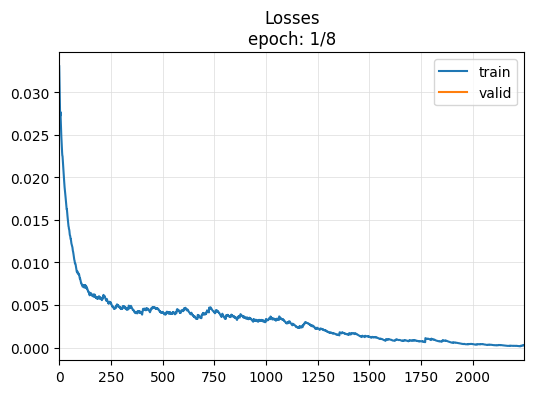

Epoch 2: reducing lr to 9.330715328850895e-05
Epoch 7: reducing lr to 1.0013543717086668e-09


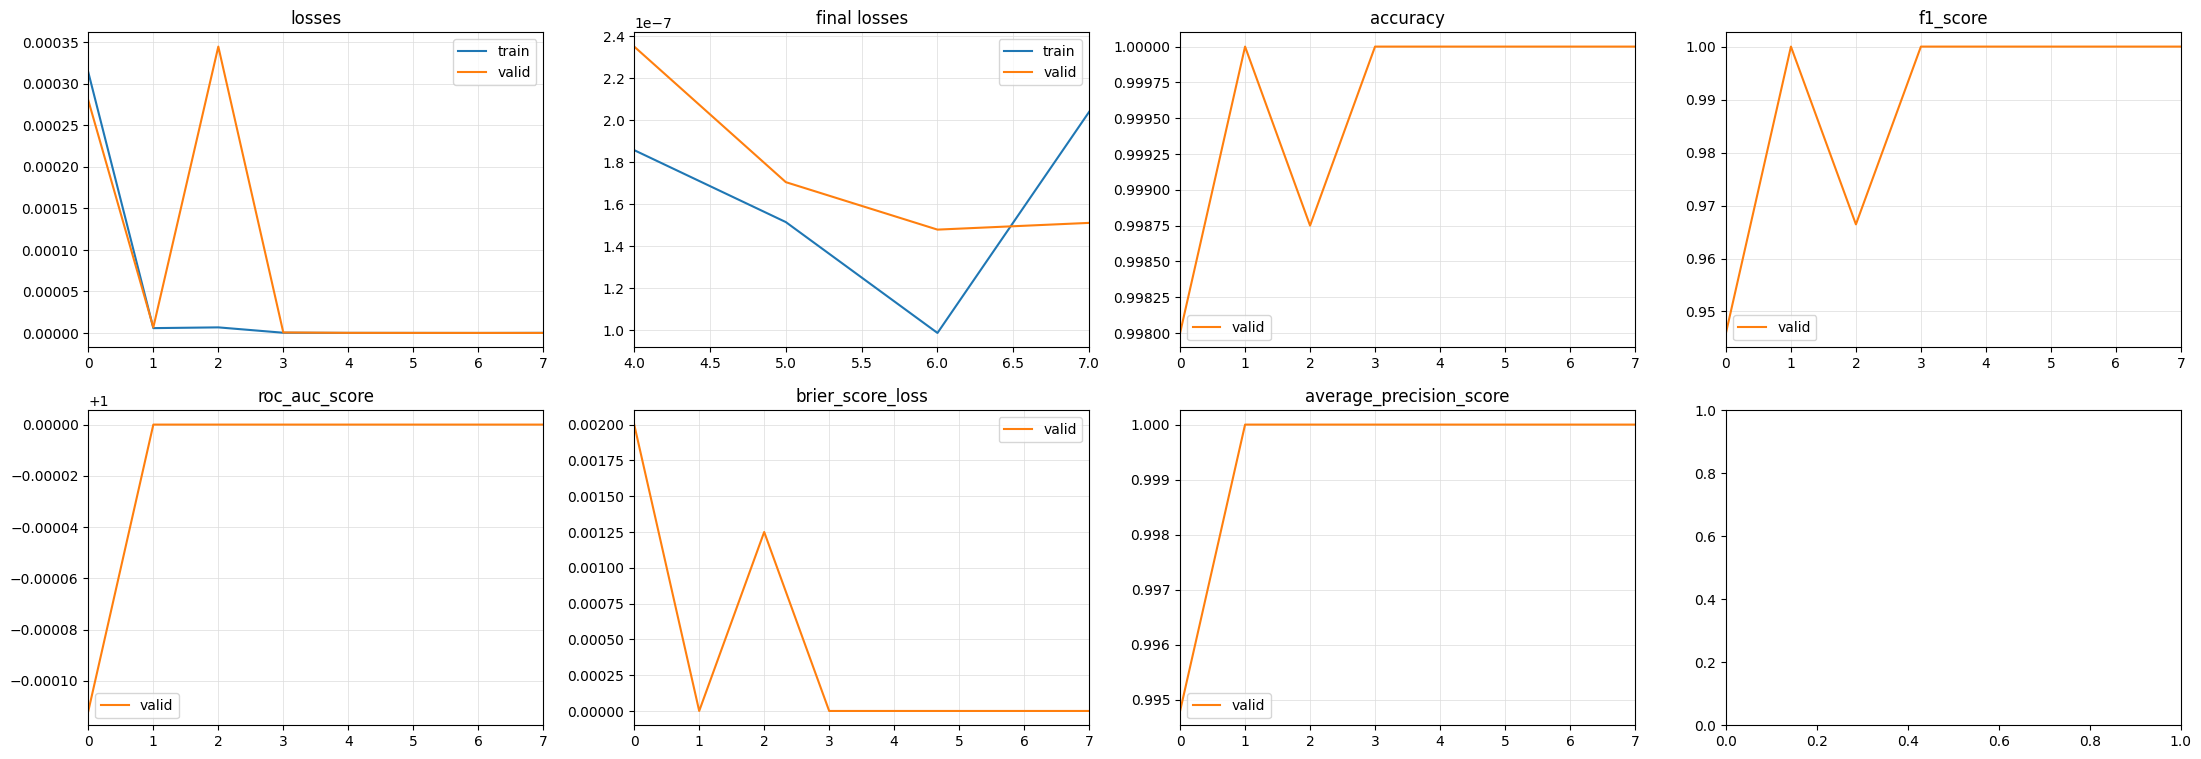

Y equal 0:
[1.1477002e-15, 0.00077644846, 0.17923008]
Y equal 1:
[0.8959369, 0.9816319, 0.9915882]
accuracy: 1.0000
precision: 1.0000
recall: 1.0000
f1: 1.0000
auc: 1.0000
prc: 1.0000
Y 0, predicted 0 (true negatives)        19614.000000
Y 0, predicted 1 (false positives)       0.000000
Y 1, predicted 0 (false negatives)       0.000000
Y 1, predicted 1 (true positives)        386.000000


(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 19614, 0, 0, 386)

In [118]:
Data_load.random_seed2(randnum,dls=dls)

model = arch(dls.vars, dls.c,dls.len)

model.to(device)

learn = Learner(
    dls, 
    model, 
    metrics=metrics,
    loss_func=FocalLossFlat(gamma=torch.tensor(gamma).to(device),weight=weights),
    cbs=[EarlyStoppingCallback(patience=ESPatience),ReduceLROnPlateau(),ShowGraph()]
    )

learn.fit_one_cycle(epochs, lr_max)

MLmodel_opt_learner.test_results(learn,X_test,Y_test)


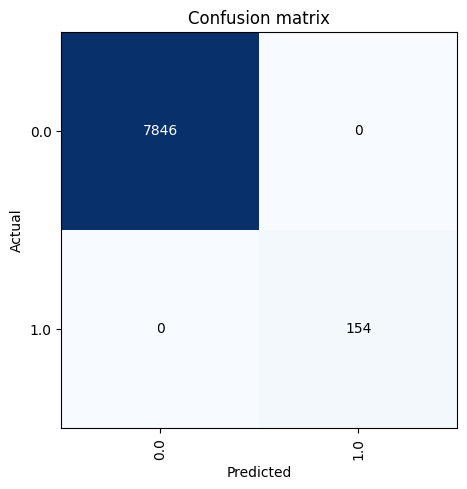

In [119]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [120]:
#valid_dl=learn.dls.valid

# obtain probability scores, predicted values and targets
#test_ds=valid_dl.dataset.add_test(X_test,Y_test)
#test_dl=valid_dl.new(test_ds)
#test_probas, test_targets,test_preds=learn.get_preds(dl=test_dl,with_decoded=True,save_preds=None,save_targs=None)


## Now we look at SHAP

In [121]:
batch = dls.one_batch()
num_samples = math.ceil(0.8*batch_size)

In [122]:
explainer = shap.GradientExplainer(
    learn.model.cpu(), torch.tensor(batch[0][:num_samples]).cpu()
)

# calculate shapely values
shap_values, indices = explainer.shap_values(
    torch.tensor(batch[0][num_samples:]).cpu(),
    ranked_outputs=2
)
#print(shap_values)

In [123]:

valid_dl=learn.dls.valid
test_ds=valid_dl.dataset.add_test(batch[0],batch[1])
test_dl=valid_dl.new(test_ds)
test_probas, test_targets,test_preds=learn.get_preds(dl=test_dl,with_decoded=True,save_preds=None,save_targs=None)

KeyError: "Label '0' was not included in the training dataset"

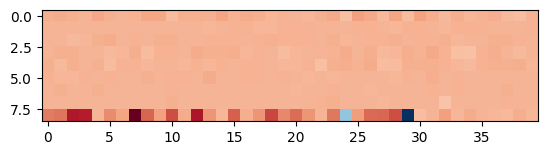

In [ ]:

shap_out=shap_values[0]
plot_shap=shap_out[3,:,:]
plot_shap_scaled=np.log((plot_shap-plot_shap.min())/(plot_shap.max()-plot_shap.min()+1e-8))
plt.imshow(plot_shap, cmap='RdBu', interpolation='nearest')
plt.show()

<Axes: >

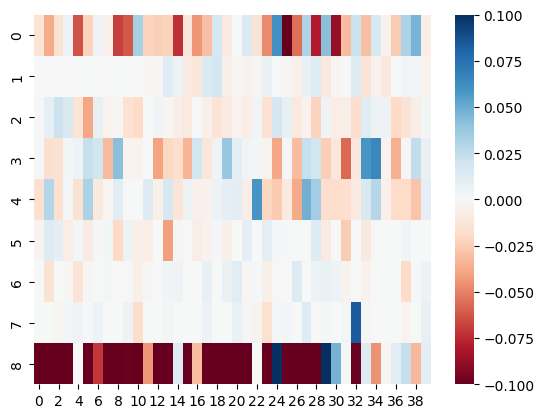

In [ ]:
sns.heatmap(data=plot_shap, cmap='RdBu',vmin=-0.1,center=0,vmax=0.1)

In [ ]:
neg_idx = np.where(np.array(batch[1][num_samples:].cpu())==0)
pos_idx = np.where(np.array(batch[1][num_samples:].cpu())==1)

In [ ]:
little_check=batch[0][num_samples:]

pos_shap=shap_out[pos_idx,:,:]
neg_shap=shap_out[neg_idx,:,:]
pos_shap=pos_shap[0,:,:,:]
neg_shap=neg_shap[0,:,:,:]
pos_base=little_check[pos_idx,:,:]
neg_base=little_check[neg_idx,:,:]
pos_base=pos_base[0,:,:,:]
neg_base=neg_base[0,:,:,:]
pos_base=np.array(pos_base.cpu())
neg_base=np.array(neg_base.cpu())

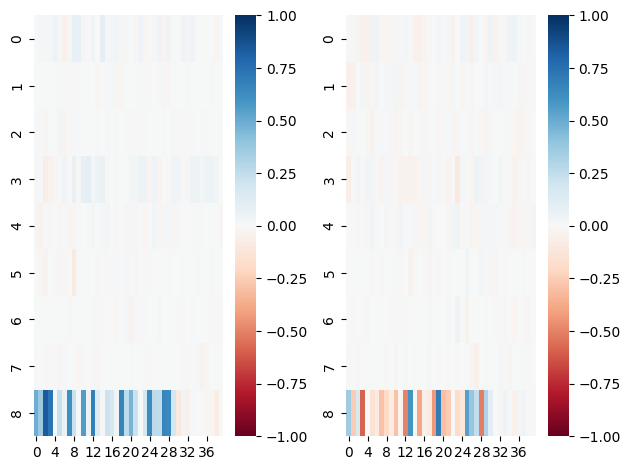

In [ ]:
fig,axes = plt.subplots(1,2)
sns.heatmap(data=pos_shap.mean(0), cmap='RdBu',vmin=-1,center=0,vmax=1,ax=axes[0])
sns.heatmap(data=neg_shap.mean(0), cmap='RdBu',vmin=-1,center=0,vmax=1,ax=axes[1])
fig.tight_layout()

In [ ]:
batch[1][num_samples:]

TensorCategory([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:1')

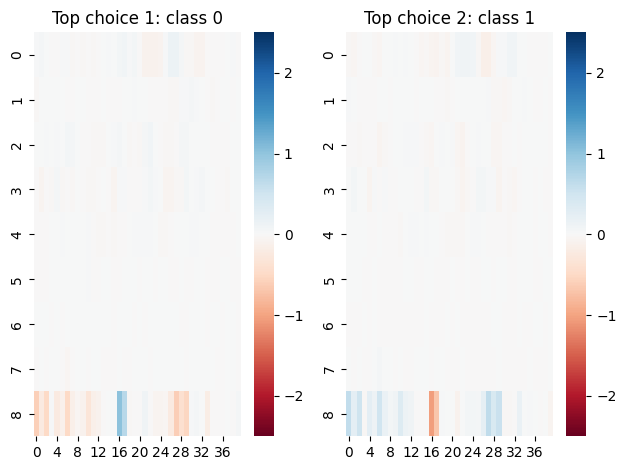

In [ ]:
shap_num=4
fig,axes = plt.subplots(1,2)
sns.heatmap(data=shap_values[0][shap_num,:,:], cmap='RdBu',vmin=-2.5,center=0,vmax=2.5,ax=axes[0])
sns.heatmap(data=shap_values[1][shap_num,:,:], cmap='RdBu',vmin=-2.5,center=0,vmax=2.5,ax=axes[1])
axes[0].set_title(f'Top choice 1: class {indices[shap_num, 0]}')
axes[1].set_title(f'Top choice 2: class {indices[shap_num, 1]}')
fig.tight_layout()

## Now looking at feature importance and step importance

X.shape: (72000, 2, 10)
y.shape: (72000,)
Selected metric: roc_auc_score
Computing feature importance (permutation method)...


  1 feature: var_1                roc_auc_score: 0.561714



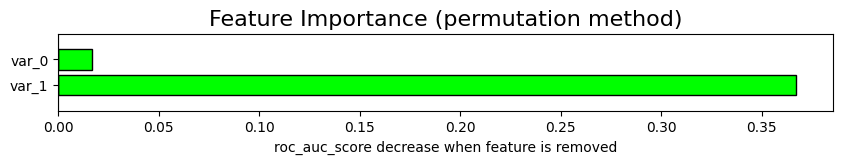

In [ ]:
feature_imp=learn.feature_importance(key_metric_idx=2)

In [ ]:
feature_imp=learn.feature_importance(key_metric_idx=4)

X.shape: (72000, 2, 10)
y.shape: (72000,)
Selected metric: roc_auc_score
Computing step importance...


 10 step: 9                    roc_auc_score: 0.922374



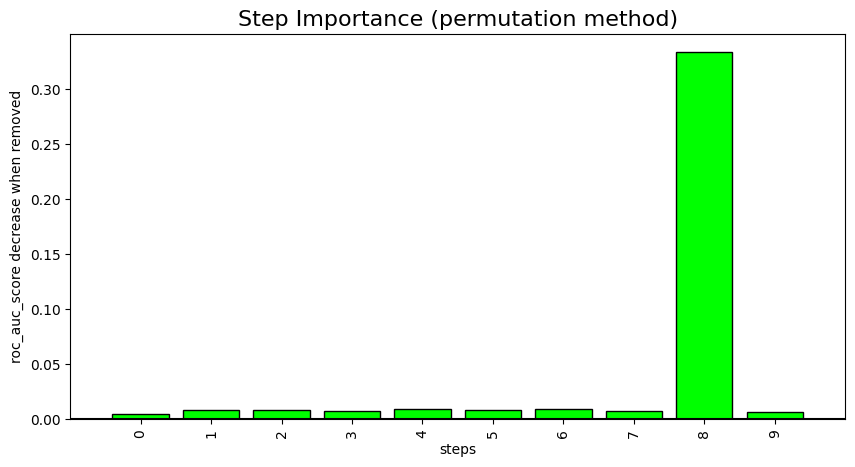

In [ ]:
step_imp=learn.step_importance (key_metric_idx=2)

In [ ]:
step_imp=learn.step_importance (key_metric_idx=4)

## Do conditional feature importance

In [ ]:
## split data set into those with and without a previous diagnosis of RTI and then do feature importance,, how best to do this?

## Now we attempt counterfactuals

In [ ]:
## some ideas of things to do
# 1. get rid of all poverty in the first 5 years of life
# 2. can't really do the medical stuff and have to assume that that is unchanged unfortunately as is not multi-class
# 3. Can increase base income
# 4. Reduce levels of parental drug or alcohol abuse

### first thing is to change X_test then put in fitted model and can see how Y_test is different and the preds are different.
X_count=copy(X_test)

## NOw set the first 5 years of life so that there is zero poverty
X_count[:,8,0:4] =0


In [ ]:

def count_results(f_model,X_test,Y_test):

    valid_dl=f_model.dls.valid

    # obtain probability scores, predicted values and targets
    test_ds=valid_dl.dataset.add_test(X_test,Y_test)
    test_dl=valid_dl.new(test_ds)
    test_probas, test_targets,test_preds=f_model.get_preds(dl=test_dl,with_decoded=True,save_preds=None,save_targs=None)

    # get the min, max and median of probability scores for each class
    print(f'sum of targets: {torch.sum(test_targets)}; sum of preds: {torch.sum(test_preds)}')
    count_y = torch.sum(test_preds)

    return count_y


count_results(learn,X_test,Y_test)
count_results(learn,X_count,Y_test)


### gives some kind of predicition for number or proportion of cases averted

sum of targets: 2983; sum of preds: 1943


sum of targets: 2983; sum of preds: 0


tensor(0)

## Now we try to do DICE

In [44]:
import dice_ml
from dice_ml.utils import helpers # helper functions
from sklearn.model_selection import train_test_split



In [ ]:


from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

import dice_ml
from dice_ml import Dice
from dice_ml.utils import helpers  # helper functions

%load_ext autoreload
%autoreload 2

#Preliminaries: Loading the data and ML model

dataset = helpers.load_adult_income_dataset().sample(5000)  # downsampling to reduce ML model fitting time
helpers.get_adult_data_info()

target = dataset["income"]

# Split data into train and test
datasetX = dataset.drop("income", axis=1)
x_train, x_test, y_train, y_test = train_test_split(datasetX,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=0,
                                                    stratify=target)

numerical = ["age", "hours_per_week"]
categorical = x_train.columns.difference(numerical)

# We create the preprocessing pipelines for both numeric and categorical data.
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

transformations = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', transformations),
                      ('classifier', RandomForestClassifier())])
model = clf.fit(x_train, y_train)

d = dice_ml.Data(dataframe=dataset, continuous_features=['age', 'hours_per_week'], outcome_name='income')
m = dice_ml.Model(model=model, backend="sklearn")

#Local feature importance

#We first generate counterfactuals for a given input point.

exp = Dice(d, m, method="random")
query_instance = x_train[1:2]
e1 = exp.generate_counterfactuals(query_instance, total_CFs=10, desired_range=None,
                                  desired_class="opposite",
                                  permitted_range=None, features_to_vary="all")
e1.visualize_as_dataframe(show_only_changes=True)

#These can now be used to calculate the feature importance scores.

imp = exp.local_feature_importance(query_instance, cf_examples_list=e1.cf_examples_list)
print(imp.local_importance)

#Feature importance can also be estimated directly, by leaving the cf_examples_list argument blank.

imp = exp.local_feature_importance(query_instance, posthoc_sparsity_param=None)
print(imp.local_importance)

##Global importance

#For global importance, we need to generate counterfactuals for a representative sample of the dataset.

cobj = exp.global_feature_importance(x_train[0:10], total_CFs=10, posthoc_sparsity_param=None)
print(cobj.summary_importance)

#Convert the counterfactual output to json

json_str = cobj.to_json()
print(json_str)

#Convert the json output to a counterfactual object

imp_r = imp.from_json(json_str)
print([o.visualize_as_dataframe(show_only_changes=True) for o in imp_r.cf_examples_list])
print(imp_r.local_importance)
print(imp_r.summary_importance)



In [ ]:

#Generating counterfactual explanations with any ML model  ## model-agnostic

#The goal of this notebook is to show how to generate CFs for ML models using frameworks other than TensorFlow or PyTorch. We show how to generate diverse CFs by three methods:

#    Independent random sampling of features (method_name='random')
#    Genetic algorithm (method_name='genetic')
#    Querying a KD tree (method_name='kdtree')

#We use scikit-learn models for demonstration.
#1. Independent random sampling of features

# import DiCE
import dice_ml
from dice_ml.utils import helpers  # helper functions

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

%load_ext autoreload
%autoreload 2

#Loading dataset

#We use the "adult" income dataset from UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/adult). We transform the data as described in dice_ml.utils.helpers module.

dataset = helpers.load_adult_income_dataset()

dataset.head()

d = dice_ml.Data(dataframe=dataset, continuous_features=['age', 'hours_per_week'], outcome_name='income')

#Training a custom ML model

#Below, we build an ML model using scikit-learn to demonstrate how our methods can work with any sklearn model.

target = dataset["income"]
# Split data into train and test
datasetX = dataset.drop("income", axis=1)
x_train, x_test, y_train, y_test = train_test_split(datasetX,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=0,
                                                    stratify=target)

numerical = ["age", "hours_per_week"]
categorical = x_train.columns.difference(numerical)

# We create the preprocessing pipelines for both numeric and categorical data.
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

transformations = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', transformations),
                      ('classifier', RandomForestClassifier())])
model = clf.fit(x_train, y_train)

# provide the trained ML model to DiCE's model object
backend = 'sklearn'
m = dice_ml.Model(model=model, backend=backend)

#Generate diverse counterfactuals

# initiate DiCE
exp_random = dice_ml.Dice(d, m, method="random")

query_instances = x_train[4:6]

# generate counterfactuals
dice_exp_random = exp_random.generate_counterfactuals(query_instances, total_CFs=2, desired_class="opposite", verbose=False)

dice_exp_random.visualize_as_dataframe(show_only_changes=True)

#It can be observed that the random sampling method produces less sparse CFs in contrast to current DiCE's implementation. The sparsity issue with random sampling worsens with increasing total_CFs

#Further, different sets of counterfactuals can be generated with different random seeds.

# generate counterfactuals
# default random seed is 17
dice_exp_random = exp_random.generate_counterfactuals(query_instances,
                                                      total_CFs=4,
                                                      desired_class="opposite",
                                                      random_seed=9)

dice_exp_random.visualize_as_dataframe(show_only_changes=True)

#Selecting the features to vary

#Here, you can ensure that DiCE varies only features that it makes sense to vary.

# generate counterfactuals
dice_exp_random = exp_random.generate_counterfactuals(
        query_instances, total_CFs=4, desired_class="opposite",
        features_to_vary=['workclass', 'education', 'occupation', 'hours_per_week'])

dice_exp_random.visualize_as_dataframe(show_only_changes=True)

#Choosing feature ranges

#Since the features are sampled randomly, they can freely vary across their range. In the below example, we show how range of continuous features can be controlled using permitted_range parameter that can now be passed during CF generation.

# generate counterfactuals
dice_exp_random = exp_random.generate_counterfactuals(
    query_instances, total_CFs=4, desired_class="opposite",
    permitted_range={'age': [22, 50], 'hours_per_week': [40, 60]})

dice_exp_random.visualize_as_dataframe(show_only_changes=True)

#2. Genetic Algorithm

#Here, we show how to use DiCE can be used to generate CFs for any ML model by using the genetic algorithm to find the best counterfactuals close to the query point. The genetic algorithm converges quickly, and promotes diverse counterfactuals.
#Training a custom ML model

#Currently, the genetic algorithm method works with scikit-learn models. We will use the same model as shown previously in the notebook. Support for Tensorflow 1&2 and Pytorch will be implemented soon.
#Generate diverse counterfactuals

# initiate DiceGenetic
exp_genetic = dice_ml.Dice(d, m, method='genetic')

# generate counterfactuals
dice_exp_genetic = exp_genetic.generate_counterfactuals(query_instances, total_CFs=4, desired_class="opposite", verbose=True)

dice_exp_genetic.visualize_as_dataframe(show_only_changes=True)

#e can also ensure that the genetic algorithm also only varies the features that you wish to vary

# generate counterfactuals
dice_exp_genetic = exp_genetic.generate_counterfactuals(
    query_instances, total_CFs=2, desired_class="opposite",
    features_to_vary=['workclass', 'education', 'occupation', 'hours_per_week'])
dice_exp_genetic.visualize_as_dataframe(show_only_changes=True)

#You can also constrain the features to vary only within the permitted range

# generate counterfactuals
dice_exp_genetic = exp_genetic.generate_counterfactuals(
    query_instances, total_CFs=2, desired_class="opposite",
    permitted_range={'age': [22, 50], 'hours_per_week': [40, 60]})
dice_exp_genetic.visualize_as_dataframe(show_only_changes=True)

#3. Querying a KD Tree

#Here, we show how to use DiCE can be used to generate CFs for any ML model by finding the closest points in the dataset that give the output as the desired class. We do this efficiently by building KD trees for each class, and querying the KD tree of the desired class to find the k closest counterfactuals from the dataset. The idea behind finding the closest points from the training data itself is to ensure that the counterfactuals displayed are feasible.
#Training a custom ML model

#Currently, the KD tree algorithm method works with scikit-learn models. Again, we will use the same model as shown previously in the notebook. Support for Tensorflow 1&2 and Pytorch will be implemented soon.
#Generate diverse counterfactuals

# initiate DiceKD
exp_KD = dice_ml.Dice(d, m, method='kdtree')

# generate counterfactuals
dice_exp_KD = exp_KD.generate_counterfactuals(query_instances, total_CFs=4, desired_class="opposite")

dice_exp_KD.visualize_as_dataframe(show_only_changes=True)

#Selecting the features to vary

#Here, again, you can vary only features that you wish to vary. Please note that the output counterfactuals are only from the training data. If you want other counterfactuals, please use the random or genetic method.

# generate counterfactuals
dice_exp_KD = exp_KD.generate_counterfactuals(
    query_instances, total_CFs=4, desired_class="opposite",
    features_to_vary=['age', 'workclass', 'education', 'occupation', 'hours_per_week'])

dice_exp_KD.visualize_as_dataframe(show_only_changes=True)

#Selecting the feature ranges

#Here, you can control the ranges of continuous features.

# generate counterfactuals
dice_exp_KD = exp_KD.generate_counterfactuals(
    query_instances, total_CFs=5, desired_class="opposite",
    permitted_range={'age': [30, 50], 'hours_per_week': [40, 60]})
dice_exp_KD.visualize_as_dataframe(show_only_changes=True)



In [26]:


# Sklearn imports
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

# DiCE imports
import dice_ml
from dice_ml.utils import helpers  # helper functions



In [27]:
%load_ext autoreload
%autoreload 2


In [45]:


dataset = helpers.load_adult_income_dataset()



In [49]:
dataset

,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,28,Private,Bachelors,Single,White-Collar,White,Female,60,0
1,30,Self-Employed,Assoc,Married,Professional,White,Male,65,1
2,32,Private,Some-college,Married,White-Collar,White,Male,50,0
3,20,Private,Some-college,Single,Service,White,Female,35,0
4,41,Self-Employed,Some-college,Married,White-Collar,White,Male,50,0
...,...,...,...,...,...,...,...,...,...
26043,28,Private,HS-grad,Married,White-Collar,White,Male,40,0
26044,18,Private,School,Single,Blue-Collar,White,Male,55,0
26045,22,Private,Some-college,Single,White-Collar,White,Female,40,0
26046,42,Self-Employed,Bachelors,Divorced,White-Collar,Other,Male,30,0


In [ ]:
df = pd.DataFrame(my_array, columns = ['Column_A','Column_B','Column_C'])


In [ ]:
## Need to put X_trainvalid and Y_trainvalid into a data set format


d = dice_ml.Data(dataframe=train_dataset, continuous_features=['age', 'hours_per_week'], outcome_name='income')


In [ ]:


target = dataset["income"]
train_dataset, test_dataset, y_train, y_test = train_test_split(dataset,
                                                                target,
                                                                test_size=0.2,
                                                                random_state=0,
                                                                stratify=target)
x_train = train_dataset.drop('income', axis=1)
x_test = test_dataset.drop('income', axis=1)

# Step 1: dice_ml.Data
d = dice_ml.Data(dataframe=train_dataset, continuous_features=['age', 'hours_per_week'], outcome_name='income')


#The loss is defined by three component: validity (does the CF have the desired model output), 
#proximity (distance of CF from original point should be low), and diversity (multiple CFs should change different features). 
#The DiCE loss formulation is described in the paper, Explaining Machine Learning Classifiers through Diverse Counterfactual Explanations.


backend = 'PYT'  # needs pytorch installed
ML_modelpath = helpers.get_adult_income_modelpath(backend=backend)
m = dice_ml.Model(model_path=ML_modelpath, backend=backend,  func="ohe-min-max")

exp = dice_ml.Dice(d, m, method="gradient")

# generate counterfactuals
dice_exp = exp.generate_counterfactuals(x_test[1:3], total_CFs=4, desired_class="opposite")
# highlight only the changes
dice_exp.visualize_as_dataframe(show_only_changes=True)

#We can also use method-agnostic explainers like "random" or "genetic".

m = dice_ml.Model(model_path=ML_modelpath, backend=backend, func="ohe-min-max")
exp = dice_ml.Dice(d, m, method="random")

# generate counterfactuals
dice_exp = exp.generate_counterfactuals(x_test[1:3], total_CFs=4, desired_class="opposite")
# highlight only the changes
dice_exp.visualize_as_dataframe(show_only_changes=True)
